In [2]:
import torch
import pandas as pd
import numpy as np

In [3]:
#data_noname = pd.read_csv('data/train_set/3.data_normalize2_noname.csv')
data = pd.read_csv('data/train_set/3.data_normalize.csv')


In [4]:
data.columns

Index(['broadcast_time', 'unit_price', 'off_day', 'hour', 'temperature_seoul',
       'rain_seoul', 'humid_seoul', 'snow_seoul', 'temperature_busan',
       'rain_busan', 'humid_busan', 'snow_busan', 'pmWarning_seoul',
       'pmWarning_busan', 'day_dup', 'week_dup', 'max_watching',
       'avg_watching', 'working_time', 'pastAvg_diff', 'handling_amount',
       'product_category_가전', 'product_category_건강기능', 'product_category_농수축',
       'product_category_생활용품', 'product_category_속옷', 'product_category_의류',
       'product_category_이미용', 'product_category_잡화', 'product_category_주방',
       'product_category_침구', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'season_2', 'season_3',
       'season_4'],
      dtype='object')

In [7]:
x_data = data.drop(columns = ['pastAvg_diff', 'handling_amount'])
y_data = data['handling_amount']

In [8]:
x_data.loc[:,'off_day'] = x_data.loc[:,'off_day'].astype('float64')
x_data.loc[:,'pmWarning_busan']= x_data.loc[:,'pmWarning_busan'].astype('float64')
x_data.loc[:,'pmWarning_seoul']= x_data.loc[:,'pmWarning_seoul'].astype('float64')
x_data.loc[:,'working_time']= x_data.loc[:,'working_time'].astype('float64')


In [9]:
from sklearn.model_selection import train_test_split
train_x, testvalid_x, train_y, testvalid_y = train_test_split(x_data, y_data, test_size = 0.2, random_state = 1)
test_x, valid_x, test_y, valid_y = train_test_split(testvalid_x, testvalid_y, test_size = 0.5, random_state = 1)

### 모델 만들기
https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/

In [10]:
# preprocess, set hyperparameter
import argparse
import os

# load data
from torch.utils.data import DataLoader

# train
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

# visualization
import matplotlib.pyplot as plt

In [11]:
max_epoch = 100
max_patience = 3
batch_size = 32
input_size = len(train_x.columns)
output_size = 1
log_interval = 300
criterion = nn.MSELoss()


40

In [12]:
import pdb
class DataIterator:
    def __init__(self, X,Y, batch_size):
        self.x = torch.from_numpy(X.values).unsqueeze(dim=1)
        self.y = torch.from_numpy((Y.values)/1000).unsqueeze(dim=1) # 10000으로 나눠줌
        self.batch_size = batch_size
        self.start_index = 0

    def __iter__(self):
        return self

    def __next__(self):
        start_index = self.start_index
        end_index = start_index + self.batch_size
        x_data = self.x[start_index : start_index + self.batch_size]
        y_data = self.y[start_index : start_index + self.batch_size]
        if(x_data.shape[0] != self.batch_size):  # small frag TODO
            raise StopIteration
        self.start_index += self.batch_size
        return x_data, y_data

for x_data, y_data in DataIterator(train_x, train_y, 32): 
    pass


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self,input_size, output_size):
        super(DNN, self).__init__()
        hds1=30
        hds2=20
        hds3=10
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hds1)
        self.fc2 = nn.Linear(hds1, hds2)
        self.fc3 = nn.Linear(hds2, hds3)

        self.fc4 = nn.Linear(hds3, output_size)
        self.ELU =nn.ELU()

    def forward(self, x):
        h1 = self.ELU(self.fc1(x.float().view(-1, self.input_size)))
        h2 = self.ELU(self.fc2(h1))
        h3 = self.ELU(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4


In [16]:
from torch import nn
model = DNN(input_size, output_size)
optimizer = optim.Adam(model.parameters())

# train
idx = 0
best_loss =0
for epoch in range(max_epoch):
    loss_sum =0
    idx = 0
    model.train()
    for x_data, y_data in DataIterator(train_x, train_y, batch_size): 
        idx +=1
        optimizer.zero_grad()
        output = model(x_data.float())
        loss = criterion(output, y_data.float())
        loss_sum += loss
        loss.backward()
        optimizer.step()
        if(idx % log_interval == 0):
            #print("epoch : " + str(epoch) + " loss : " + str(int(loss_sum/(log_interval))))
            pass
    
    model.eval()
    loss_sum =0
    print("=====validation=====")
    idx =0
    for x_data, y_data in DataIterator(valid_x, valid_y, batch_size): 
        idx +=1
        output = model(x_data.float())
        loss = criterion(output, y_data.float())
        loss_sum += loss
    print("epoch : "  + str(eopch+1))
    print("loss " + str(int(loss_sum/idx)))

        
    if(best_loss == 0 or best_loss>loss_sum):
        print("find new best")
        best_loss = loss_sum
        patience =0
    else:
        patience +=1
    if(patience >max_patience):
        print("early stopping")
        break


# test
model.eval()
loss_sum =0
abs_loss =0 
idx =0 
outputs = []
ys = []
for x_data, y_data in DataIterator(test_x, test_y, batch_size): 
    idx +=1
    output = model(x_data.float())
    outputs.append(output)
    ys.append(y_data)
    loss = criterion(output, y_data.float())
    loss_sum += loss
print('total loss : '+str(int(loss_sum/idx) ))
print(output)

    



=====validation=====
loss 349703648
find new best
=====validation=====
loss 311914752
find new best
=====validation=====
loss 291393216
find new best
=====validation=====
loss 282580224
find new best
=====validation=====
loss 278323488
find new best
=====validation=====
loss 275812000
find new best
=====validation=====
loss 274030880
find new best
=====validation=====
loss 272578752
find new best
=====validation=====
loss 271279680
find new best
=====validation=====
loss 270092928
find new best
=====validation=====
loss 268982112
find new best
=====validation=====
loss 267917488
find new best
=====validation=====
loss 266879008
find new best
=====validation=====
loss 265843312
find new best
=====validation=====
loss 264786976
find new best
=====validation=====
loss 263759040
find new best
=====validation=====
loss 262703136
find new best
=====validation=====
loss 261611392
find new best
=====validation=====
loss 260403056
find new best
=====validation=====
loss 259190208
find new best


#### 기록 : 1번파일 -> loss 12,438,049,128,448 early stopping total loss : 12,910,166,278,144
#### 기록 : 2번파일 1000으로 나누었을때 중간에러 -> 12,906,635,000(다시 1000 곱해줌)
#### 기록 : 2번파일 10000으로 나누었을때 중간에러 -> 2867223(다시 1000 곱해줌)
=====validation=====
loss 5705414
find new best
=====validation=====
loss 3490570
find new best
=====validation=====
loss 3225345
find new best
=====validation=====
loss 3023757
find new best
=====validation=====
loss 2915842
find new best
=====validation=====
loss 2854653
find new best


#### -> mse 식 수정

In [17]:
new_output = []
new_y = []
for i in range(len(outputs)):
    new_output.append(outputs[i].detach().numpy().squeeze())
    new_y.append(ys[i].numpy().squeeze())

new_output = np.array(new_output).reshape(-1)
new_y = np.array(new_y).reshape(-1)

In [18]:
temp = pd.DataFrame(index = range(0,len(new_output)),data = {'output' : new_output, 'y' : new_y})
temp = temp.reset_index()

In [19]:
temp['diff'] = temp['y'] - temp['output']
temp['diff_abs'] = abs(temp['diff'])

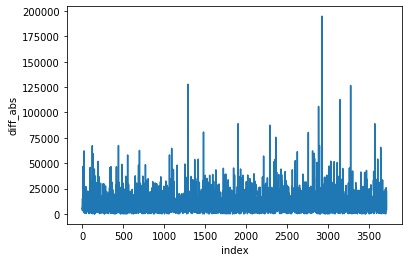

In [21]:
import seaborn as sns
sns.lineplot(data = temp,x = "index", y = 'diff_abs')

In [22]:
temp['diff_abs'].mean()

10515.80141804727

{'whiskers': [<matplotlib.lines.Line2D at 0x1ea24d16648>,
 'caps': [<matplotlib.lines.Line2D at 0x1ea24db0a48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ea24dab708>],
 'medians': [<matplotlib.lines.Line2D at 0x1ea24db5f88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ea24dba888>],
 'means': []}

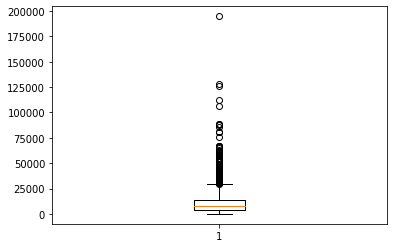

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot(temp['diff_abs'])